Using kernel `conda_pytorch_latest_p36`

# Import

In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
import sys
sys.path.append('../../../')

In [3]:
from pathlib import Path
import os
import random
import pickle
import tarfile
from typing import List
from dataclasses import dataclass

In [4]:
import pandas as pd
import numpy as np
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast, Trainer, TrainingArguments
from sklearn.metrics import classification_report, precision_recall_fscore_support, precision_score, f1_score, recall_score, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import boto3
from langdetect import detect

In [5]:
from deep.constants import *

# Fastai

In [6]:
def preprocessing(df):
    df = df.copy()
    df['sectors'] = df['sectors'].apply(eval)    
    df['pillars'] = df['pillars'].apply(eval)
    df['pillars'] = df['pillars'].apply(lambda x: list(set(x)))
    df['subpillars'] = df['subpillars'].apply(eval)
    return df

def process_multiclass(df, train, column='pillars', classes=PILLARS):
    relevant_train = df.copy()
    relevant_train = relevant_train[relevant_train[column].apply(len) > 0]
    relevant_train[label_column] = relevant_train.pillars + relevant_train.subpillars
    relevant_train[label_column] = relevant_train[label_column].apply(lambda x: ';'.join(x))
    
    relevant_train['is_valid'] = False if train else True
    
    return relevant_train
    

train = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_train.csv'))
val = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_val.csv'))
test = preprocessing(pd.read_csv(LATEST_DATA_PATH / 'data_v0.4.4_test.csv'))

column = 'subpillars'
classes=SUBPILLARS
text_column = 'excerpt'
label_column = 'merged'
train_df = process_multiclass(train, True, column=column, classes=classes)
test_df = process_multiclass(test, False, column=column, classes=classes)
df = pd.concat([train_df, test_df])

In [8]:
train

,Unnamed: 0,entry_id,lead_id,project_id,project_title,analysis_framework_id,excerpt,dropped_excerpt,created_by_id,modified_by_id,verified,verification_last_changed_by_id,language,sectors,pillars,subpillars
0,0,163664,35315,2028,IMMAP/DFS Syria,1306,Market monitoring by the World Food Programme ...,NaN,2232,2232,False,NaN,en,[Food Security],[Impact],[Impact->Impact On Systems And Services]
1,1,162812,37820,2098,IMMAP/DFS Bangladesh,1306,Quarantine Facilities: ninety-three shelters i...,NaN,657,2233,False,NaN,en,[Health],[Capacities & Response],[Capacities & Response->International Response]
2,2,164560,39796,2098,IMMAP/DFS Bangladesh,1306,"Within dimensions, markets are broadly operati...",NaN,1152,1152,False,NaN,en,[Cross],[Impact],[Impact->Impact On Systems And Services]
3,3,157496,38706,2098,IMMAP/DFS Bangladesh,1306,Frontline aid workers face a heightened risk o...,NaN,2233,2233,False,NaN,en,"[Health, Logistics]","[People At Risk, Impact]","[Impact->Driver/Aggravating Factors, People At..."
4,4,170866,37673,1142,IFRC Turkey,699,[COVID] TRC is currently using its different c...,NaN,2233,2233,False,NaN,en,[Health],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90648,90648,282949,51241,2170,IMMAP/DFS Nigeria,1306,"[16th Mar 2021,North east Nigeria]The governme...",NaN,2230,26,True,26.0,en,[Cross],[Impact],[Impact->Impact On Systems And Services]
90649,90649,283375,51241,2170,IMMAP/DFS Nigeria,1306,"[16th Mar 2021,North east Nigeria] Impact on s...",NaN,2230,1152,True,1152.0,en,"[Health, Education, Protection, Livelihoods]","[Impact, Humanitarian Conditions]","[Impact->Driver/Aggravating Factors, Humanitar..."
90650,90650,268927,49888,2331,GIMAC Somalia,1465,A reported 14 per cent of women aged 15-49 had...,NaN,2741,2272,True,488.0,en,[Protection],[],[]
90651,90651,268842,49945,2311,IMMAP/DFS Colombia,1306,La alternancia no es solo plantear cuáles niño...,La alternancia no es solo plantear cuáles niño...,2374,2374,True,1403.0,es,[Education],[Impact],[Impact->Impact On Systems And Services]


In [7]:
TMP_DIR = Path('./remote-jobs')
MERGED_PATH = Path('models/pytorch-training-2021-06-03-15-28-53-523-fastai-merged/output/output.tar.gz')
SUBPILLAR_PATH = Path('models/pytorch-training-2021-06-03-16-44-29-318-fastai-subpillar/output/output.tar.gz')
EPOCHS5_PATH = Path('models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output/output.tar.gz')
RESAMPLED5_PATH = Path('models/pytorch-2021-06-03-17-47-47-773-fastai-5ep-resampled/output/output.tar.gz')
ENGLISH_PATH = Path('models/pytorch-2021-06-07-11-32-34-795-fastai-5ep-english/output/output.tar.gz')
ENTAILMENT_PATH = Path('models/pytorch-2021-06-08-16-02-55-469-fastai-entail-english/output/output.tar.gz')

In [28]:
def download_locally(remote_path):
    local_file = TMP_DIR / remote_path
    local_file.parent.mkdir(exist_ok=True, parents=True)
    s3 = boto3.client('s3')
    s3.download_file(DEV_BUCKET.name, str(remote_path), str(local_file))
    with tarfile.open(local_file) as f:
        f.extractall(local_file.parent)
    print(local_file.parent)
    return local_file.parent

In [29]:
merged_path = download_locally(MERGED_PATH)
subpillar_path = download_locally(SUBPILLAR_PATH)
epochs5_path = download_locally(EPOCHS5_PATH)
resampled5_path = download_locally(RESAMPLED5_PATH)
english_path = download_locally(ENGLISH_PATH)
entail_path = download_locally(ENTAILMENT_PATH)

remote-jobs/models/pytorch-training-2021-06-03-15-28-53-523-fastai-merged/output
remote-jobs/models/pytorch-training-2021-06-03-16-44-29-318-fastai-subpillar/output
remote-jobs/models/pytorch-2021-06-03-17-24-17-144-fastai-5ep-merged/output
remote-jobs/models/pytorch-2021-06-03-17-47-47-773-fastai-5ep-resampled/output
remote-jobs/models/pytorch-2021-06-07-11-32-34-795-fastai-5ep-english/output
remote-jobs/models/pytorch-2021-06-08-16-02-55-469-fastai-entail-english/output


In [30]:
@dataclass
class FastaiResults:
    classes: List
    train_preds: pd.DataFrame
    train_targets: pd.DataFrame
    test_preds: pd.DataFrame
    test_targets: pd.DataFrame
        
    @staticmethod
    def from_path(path):
        classes = pd.read_pickle(path / 'classes.pickle')
        train_preds = pd.read_pickle(path / 'train_preds.pickle')
        train_targets = pd.read_pickle(path / 'train_targets.pickle')
        test_preds = pd.read_pickle(path / 'test_preds.pickle')
        test_targets = pd.read_pickle(path / 'test_targets.pickle')
        return FastaiResults(
            classes,
            train_preds,
            train_targets,
            test_preds,
            test_targets,
        )
    
    def get_metrics(self, tresh):
        preds = (self.test_preds > tresh).int()
        targets = self.test_targets.int()
        
        indexes = []
        recalls = []
        precisions = []
        f1_scores = []
        counts = []

        for i, class_ in enumerate(self.classes):
            class_preds = preds[:, i]
            class_targets = targets[:, i]

            indexes.append(class_)
            precisions.append(precision_score(class_targets, class_preds))
            recalls.append(recall_score(class_targets, class_preds))    
            f1_scores.append(f1_score(class_targets, class_preds))  
            counts.append(int(class_targets.sum()))

        indexes.append('all')
        precisions.append(precision_score(targets.view(-1), preds.view(-1)))
        recalls.append(recall_score(targets.view(-1), preds.view(-1)))    

        f1_scores.append(f1_score(targets.view(-1), preds.view(-1)))  
        counts.append(int(targets.view(-1).sum()))


        all_metrics = pd.DataFrame(
            {
                'class': indexes,
                'recall': recalls,
                'precision': precisions,
                'f1_score': f1_scores,
                'counts': counts
            }
        ).set_index('class', drop=True)

        return all_metrics

In [63]:
merged_results = FastaiResults.from_path(merged_path)
subpillar_results = FastaiResults.from_path(subpillar_path)
epochs5_results = FastaiResults.from_path(epochs5_path)
resampled5_results = FastaiResults.from_path(resampled5_path)
english_results = FastaiResults.from_path(english_path)
entail_results = FastaiResults.from_path(entail_path)

In [64]:
entail_results.test_preds.shape

torch.Size([20316, 2])

In [65]:
test_df.shape

(6516, 18)

In [66]:
preds = entail_results.test_preds.argmax(1)

In [67]:
targets = entail_results.test_targets

In [71]:
PILLARS

['Humanitarian Conditions',
 'Capacities & Response',
 'Impact',
 'Priority Interventions',
 'People At Risk',
 'Priority Needs']

In [74]:
recalls, precisions, f1_scores = [], [], []
for i,pillar in enumerate(PILLARS):
    pillar_preds = preds[i::6]
    pillar_targets = targets[i::6]
    
    
    recalls.append(recall_score(pillar_targets, pillar_preds))
    precisions.append(precision_score(pillar_targets, pillar_preds))
    f1_scores.append(f1_score(pillar_targets, pillar_preds))
    
a = pd.DataFrame(index=PILLARS, data={'recall': recalls, 'precision': precisions, 'f1_score': f1_scores})

In [75]:
a

,recall,precision,f1_score
Humanitarian Conditions,0.789607,0.783648,0.786616
Capacities & Response,0.795082,0.854626,0.823779
Impact,0.755058,0.801995,0.777819
Priority Interventions,0.713115,0.685039,0.698795
People At Risk,0.631707,0.703804,0.665810
Priority Needs,0.283784,0.567568,0.378378


In [36]:
entail_results.test_preds.shape

torch.Size([20316, 2])

In [14]:
merged_metrics = merged_results.get_metrics(0.15)
subpillar_metrics = subpillar_results.get_metrics(0.15)
epochs5_metrics = epochs5_results.get_metrics(0.4)
english_metrics = english_results.get_metrics(0.35)

/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib

In [16]:
epochs5_metrics.loc[PILLARS]

,recall,precision,f1_score,counts
class,,,,
Humanitarian Conditions,0.910359,0.721959,0.805286,3514
Capacities & Response,0.736842,0.727113,0.731945,1121
Impact,0.735735,0.707393,0.721285,2471
Priority Interventions,0.612565,0.672414,0.641096,191
People At Risk,0.377854,0.646484,0.476945,876
Priority Needs,0.301310,0.526718,0.383333,229


In [17]:
english_metrics.loc[PILLARS]

,recall,precision,f1_score,counts
class,,,,
Humanitarian Conditions,0.914449,0.716129,0.803228,1578
Capacities & Response,0.840164,0.828841,0.834464,732
Impact,0.828757,0.751146,0.788045,1384
Priority Interventions,0.737705,0.671642,0.703125,122
People At Risk,0.697561,0.639821,0.667445,410
Priority Needs,0.418919,0.563636,0.480620,74


In [117]:
test_preds, test_targets = english_results.test_preds, english_results.test_targets
train_preds, train_targets = english_results.train_preds, english_results.train_targets

In [118]:
def normalize(df):
    correspondences = {
        subpillar: subpillar.split('->')[0]
        for subpillar in SUBPILLARS
    }
    for subp, pil in correspondences.items():
        df[subp] *= df[pil]
    return df[SUBPILLARS]

In [119]:
df_train = normalize(pd.DataFrame(train_preds, columns=resampled5_results.classes))
df_test = normalize(pd.DataFrame(test_preds, columns=resampled5_results.classes))
train_targets = pd.DataFrame(train_targets, columns=resampled5_results.classes)[SUBPILLARS]
test_targets = pd.DataFrame(test_targets, columns=resampled5_results.classes)[SUBPILLARS]

In [120]:
def get_threshold_metrics(preds, targets, num_thresholds):
    thresholds = [x/num_thresholds for x in range(num_thresholds)]

    recalls = []
    precisions = []
    f1_scores = []

    for threshold in thresholds:
        t_preds = (preds.flatten().numpy() > threshold).astype(int)
        t_targets = targets.flatten().numpy()
        precisions.append(precision_score(t_targets, t_preds))
        recalls.append(recall_score(t_targets, t_preds))    
        f1_scores.append(f1_score(t_targets, t_preds))        
        
    all_metrics = pd.DataFrame(
        {
            'threshold': thresholds,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores
        }
    ).set_index('threshold', drop=True)

    return all_metrics

In [121]:
def get_best_threshold(preds, targets, num_thresholds=20):
    train_metrics = get_threshold_metrics(preds, targets, num_thresholds)
    best_threshold = train_metrics.f1_score.idxmax()
    
    return best_threshold, train_metrics

In [122]:
def get_metrics(preds, targets, threshold, classes):
    preds = (preds > threshold).int()
    targets = targets.int()

    indexes = []
    recalls = []
    precisions = []
    f1_scores = []
    counts = []

    for i, class_ in enumerate(classes):
        class_preds = preds[:, i]
        class_targets = targets[:, i]

        indexes.append(class_)
        precisions.append(precision_score(class_targets, class_preds))
        recalls.append(recall_score(class_targets, class_preds))    
        f1_scores.append(f1_score(class_targets, class_preds))  
        counts.append(int(class_targets.sum()))

    indexes.append('all')
    precisions.append(precision_score(targets.flatten(), preds.flatten()))
    recalls.append(recall_score(targets.flatten(), preds.flatten()))    

    f1_scores.append(f1_score(targets.flatten(), preds.flatten()))  
    counts.append(int(targets.flatten().sum()))


    all_metrics = pd.DataFrame(
        {
            'class': indexes,
            'recall': recalls,
            'precision': precisions,
            'f1_score': f1_scores,
            'counts': counts
        }
    ).set_index('class', drop=True)

    return all_metrics

In [123]:
get_best_threshold(torch.tensor(df_train.values), torch.tensor(train_targets.values))

(0.25,
              recall  precision  f1_score
 threshold                               
 0.00       1.000000   0.076768  0.142590
 0.05       0.910616   0.455534  0.607279
 0.10       0.857912   0.548337  0.669049
 0.15       0.813644   0.609741  0.697088
 0.20       0.771194   0.659938  0.711242
 0.25       0.729303   0.701350  0.715053
 0.30       0.686271   0.735999  0.710266
 0.35       0.644113   0.768557  0.700853
 0.40       0.603699   0.795591  0.686488
 0.45       0.563844   0.820967  0.668535
 0.50       0.524110   0.843438  0.646492
 0.55       0.485903   0.863215  0.621797
 0.60       0.445926   0.882079  0.592380
 0.65       0.406022   0.900237  0.559638
 0.70       0.363379   0.916366  0.520397
 0.75       0.321196   0.933094  0.477889
 0.80       0.273461   0.947262  0.424403
 0.85       0.222211   0.961401  0.360987
 0.90       0.157555   0.974801  0.271266
 0.95       0.079129   0.987296  0.146516)

In [124]:
metrics = get_metrics(torch.tensor(df_test.values), torch.tensor(test_targets.values), 0.25, SUBPILLARS)

/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
/Users/stefano/miniconda3/envs/deep-exp/lib/python3.9/site-packages/sklearn/metrics/_c

In [125]:
merg_metrics = merged_metrics.loc[SUBPILLARS]
sub_metrics = subpillar_metrics.loc[SUBPILLARS]
ep5_metrics = epochs5_metrics.loc[SUBPILLARS]

In [126]:
joined = merg_metrics.join(ep5_metrics, rsuffix='_5').join(metrics, rsuffix='_new')

In [127]:
joined[['f1_score', 'f1_score_5', 'f1_score_new']]

,f1_score,f1_score_5,f1_score_new
class,,,
Capacities & Response->International Response,0.681855,0.724974,0.755037
Capacities & Response->National Response,0.406795,0.490506,0.384491
Capacities & Response->Number Of People Reached,0.665208,0.721485,0.758242
Capacities & Response->Response Gaps,0.000000,0.000000,0.000000
Humanitarian Conditions->Coping Mechanisms,0.367133,0.337182,0.550523
Humanitarian Conditions->Living Standards,0.605734,0.679237,0.665037
Humanitarian Conditions->Number Of People In Need,0.496241,0.523741,0.734694
Humanitarian Conditions->Physical And Mental Well Being,0.556456,0.701981,0.781609
Impact->Driver/Aggravating Factors,0.456876,0.471000,0.563945


<AxesSubplot:xlabel='class'>

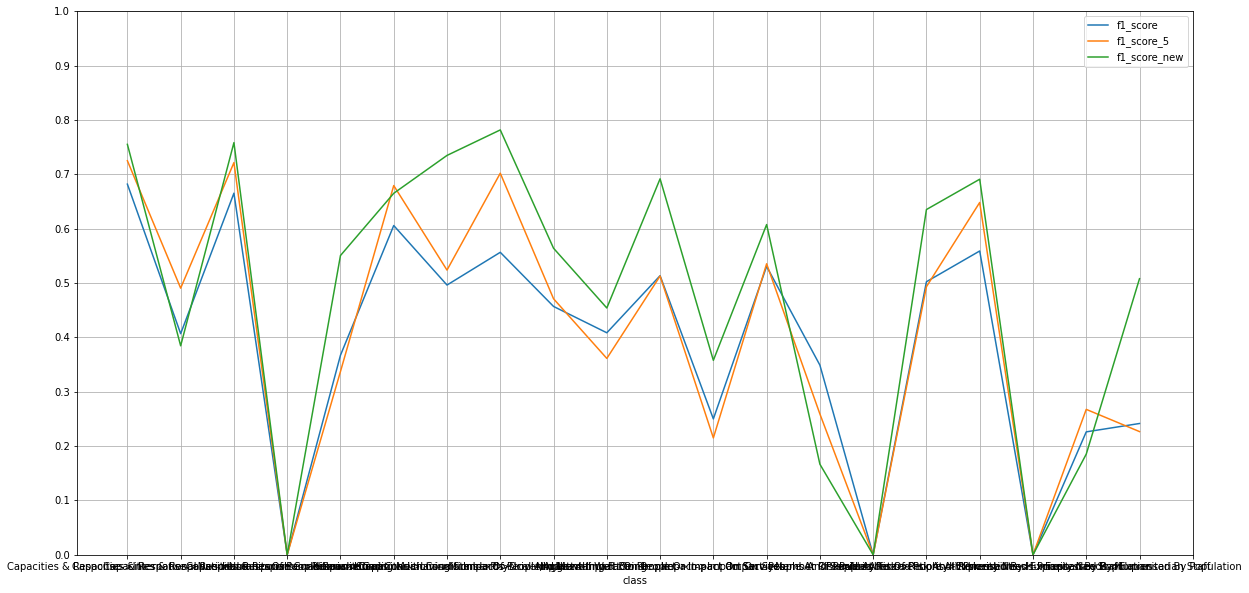

In [128]:
joined[['f1_score', 'f1_score_5', 'f1_score_new']].plot(figsize=(20, 10), xticks=range(len(SUBPILLARS)+1), yticks=[x/10 for x in range(11)], ylim=(0, 1), grid=True)

# Inspect results

In [76]:
resampled5_results.classes

['Capacities & Response',
 'Capacities & Response->International Response',
 'Capacities & Response->National Response',
 'Capacities & Response->Number Of People Reached',
 'Capacities & Response->Response Gaps',
 'Humanitarian Conditions',
 'Humanitarian Conditions->Coping Mechanisms',
 'Humanitarian Conditions->Living Standards',
 'Humanitarian Conditions->Number Of People In Need',
 'Humanitarian Conditions->Physical And Mental Well Being',
 'Impact',
 'Impact->Driver/Aggravating Factors',
 'Impact->Impact On People',
 'Impact->Impact On People Or Impact On Services',
 'Impact->Impact On Services',
 'Impact->Impact On Systems And Services',
 'Impact->Number Of People Affected',
 'People At Risk',
 'People At Risk->Number Of People At Risk',
 'People At Risk->Risk And Vulnerabilities',
 'Priority Interventions',
 'Priority Interventions->Expressed By Humanitarian Staff',
 'Priority Interventions->Expressed By Population',
 'Priority Needs',
 'Priority Needs->Expressed By Humanitaria

In [77]:
for i, x in enumerate(resampled5_results.test_targets[0]):
    if x:
        print(resampled5_results.classes[i])

Humanitarian Conditions
Humanitarian Conditions->Coping Mechanisms
Humanitarian Conditions->Living Standards
Humanitarian Conditions->Physical And Mental Well Being
People At Risk
People At Risk->Risk And Vulnerabilities


In [70]:
resampled5_results.test_preds

tensor([[3.3425e-03, 5.0780e-07, 7.9411e-06,  ..., 9.6688e-05, 1.3268e-09,
         3.6622e-09],
        [9.9735e-01, 9.9367e-01, 1.7090e-01,  ..., 7.5125e-08, 6.7299e-15,
         9.7276e-15],
        [1.7258e-03, 1.2547e-07, 1.0205e-05,  ..., 7.3872e-06, 9.4831e-11,
         3.2621e-13],
        ...,
        [1.3767e-01, 1.5621e-04, 1.3215e-02,  ..., 5.8271e-01, 1.3070e-02,
         3.3862e-01],
        [4.6626e-03, 6.0594e-07, 4.6855e-05,  ..., 7.4559e-06, 1.2523e-11,
         8.9302e-11],
        [8.8518e-01, 1.0324e-01, 6.8829e-01,  ..., 3.3534e-06, 2.3583e-11,
         1.9363e-11]])

In [96]:
classes = np.array(resampled5_results.classes)

In [106]:
for text, pred, target in zip(test_df.excerpt, resampled5_results.test_preds, resampled5_results.test_targets):
    print(text)
    print(sorted(classes[pred>0.15]))
    print(sorted(classes[target==1]))
    
    
    a = input()
    if a == 's':
        break

What this means is that families across the country can no longer afford the very basics. And food security and nutrition indicators clearly reflect that. Some 9.3 million people are food insecure. More than 2 million more are at risk of becoming food insecure. 86 per cent of households say they are buying lower quality food, or less food, or skipping meals.
['Humanitarian Conditions', 'Humanitarian Conditions->Coping Mechanisms', 'Humanitarian Conditions->Living Standards', 'Humanitarian Conditions->Physical And Mental Well Being', 'People At Risk', 'People At Risk->Risk And Vulnerabilities']
['Humanitarian Conditions', 'Humanitarian Conditions->Coping Mechanisms', 'Humanitarian Conditions->Living Standards', 'Humanitarian Conditions->Physical And Mental Well Being', 'People At Risk', 'People At Risk->Risk And Vulnerabilities']

Dispatch and Referral Unit (DRU): IOM continues to coordinate an expanded fleet of 22 vehicles, 11 of which are supplied by IOM and staffed with drivers fully

In [102]:
target

tensor([0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0.])

array(['Capacities & Response',
       'Capacities & Response->National Response',
       'Humanitarian Conditions', 'People At Risk'], dtype='<U55')